In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pickle

# machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error

import xgboost as xgb

In [59]:
file = open("../../data/features/2019_05_17_features_finally2.pickle",'rb')
df = pickle.load(file, encoding='utf-8')
df[['Time']].head()

,Time
162,20:16:00
163,19:40:00
164,09:24:00
165,09:21:00
166,08:50:00


In [60]:
df.shape

(4366, 31)

In [61]:
print(df.isnull().sum())
print(df.dtypes)

id                       0
Datetime                 0
text                     0
sentiment                0
subjectivity             0
isreply                  0
keyword                  0
year                     0
month                    0
day                      0
date                     0
DayofWeek                0
Weekend                  0
Time                     0
BinaryTrading            0
DayDistance              0
gtrend                   0
CommentSentimental       0
CommentSubjectivity      0
countComment             0
posCommentSum            0
negCommentSum            0
CommentSD                0
posCommentSD             0
negCommentSD             0
negCommentPercent        0
posCommentPercent        0
Volume_perc              0
Trading_Hour             0
AR_pred                  0
Residual               162
dtype: int64
id                                  object
Datetime               datetime64[ns, UTC]
text                                object
sentiment            

In [62]:
# drop one observation with NaN 'employer_yr_established'
# df = df[np.isfinite(df['That_hour_residual'])]
df = df.drop(['id','text','date','Time','Residual','AR_pred'],1)
df.head()

,Datetime,sentiment,subjectivity,isreply,keyword,year,month,day,DayofWeek,Weekend,...,countComment,posCommentSum,negCommentSum,CommentSD,posCommentSD,negCommentSD,negCommentPercent,posCommentPercent,Volume_perc,Trading_Hour
162,2019-04-02 20:16:00+00:00,0.00,0.0000,0,False,2019,4,2,1,False,...,757,65.808511,-9.349753,0.215552,0.252742,0.181753,0.059445,0.229855,0.307817,1.0
163,2019-04-02 19:40:00+00:00,0.00,0.0000,1,False,2019,4,2,1,False,...,125,11.632089,-1.938889,0.219263,0.242682,0.245950,0.064000,0.288000,0.307817,1.0
164,2019-04-02 09:24:00+00:00,0.15,0.4125,1,False,2019,4,2,1,False,...,29,3.081250,-0.454167,0.198969,0.178780,0.142542,0.103448,0.344828,0.307817,1.0
165,2019-04-02 09:21:00+00:00,0.00,0.0000,0,False,2019,4,2,1,False,...,243,20.762614,-5.672222,0.222568,0.223982,0.190050,0.065844,0.234568,0.307817,1.0
166,2019-04-02 08:50:00+00:00,0.00,0.0000,1,False,2019,4,2,1,False,...,76,3.768669,-2.215972,0.179058,0.229078,0.171248,0.144737,0.184211,0.307817,1.0


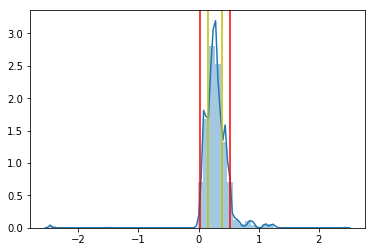

Volume_perc    0.064262
dtype: float64

In [63]:
import seaborn as sns
sns.distplot(df[['Volume_perc']].dropna())
plt.axvline(0.52, 0,3, color='r')
plt.axvline(0.027, 0,3, color='r')
plt.axvline(0.397, 0,3, color='y')
plt.axvline(0.151, 0,3, color='y')
plt.show()
df[['Volume_perc']].mean() -1*df[['Volume_perc']].std()

In [319]:
bins = pd.IntervalIndex.from_tuples([(0, 0.397), (0.397, 0.52), (0.52, 1)])
vclass= pd.cut(list(df['Volume_perc']), bins)
vclass.categories =  ['0','1','2']
np.array(vclass)
df['vclass'] = vclass

In [320]:
# df['Time_Difference'].describe()

In [32]:
df.columns
df = df.dropna()

Index(['sentiment', 'subjectivity', 'isreply', 'keyword', 'year', 'month',
       'day', 'DayofWeek', 'Weekend', 'BinaryTrading', 'DayDistance', 'gtrend',
       'CommentSentimental', 'CommentSubjectivity', 'countComment',
       'posCommentSum', 'negCommentSum', 'CommentSD', 'posCommentSD',
       'negCommentSD', 'negCommentPercent', 'posCommentPercent', 'Volume_perc',
       'Trading_Hour'],
      dtype='object')

In [57]:
# prepare X and Y

X = df[['sentiment', 'subjectivity', 'isreply','keyword', 'year', 'month', 'day',
       'DayofWeek', 'Weekend',  'BinaryTrading', 'DayDistance',
       'gtrend', 'CommentSentimental', 'CommentSubjectivity',
       'posCommentSum', 'negCommentSum', 'CommentSD', 'posCommentSD',
       'negCommentSD', 'negCommentPercent', 'posCommentPercent', 
       'Trading_Hour']]

Y = df[['Volume_perc']]

In [11]:
num_features = len(X.columns)

from sklearn.metrics import confusion_matrix
def cmatrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred, labels=['0', '1', '2'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=100)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

# print(Y_train.vclass.value_counts()/Y_train.count()[0])
# print(Y_test.vclass.value_counts()/Y_test.count()[0])



(3929, 22) (3929, 1)
(437, 22) (437, 1)


### 1. Linear Regression

In [21]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, Y_train)

print("Linear Reg R^2 training is: {}".format(linear_reg.score(X_train, Y_train)))
print("Linear Reg R^2 test data is: {}".format(linear_reg.score(X_test, Y_test)))
print("Linear Reg Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, linear_reg.predict(X_train)))))
print("Linear Reg Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, linear_reg.predict(X_test)))))


Linear Reg R^2 training is: 0.14468884309787555
Linear Reg R^2 test data is: 0.225083932985188
Linear Reg Train RMSE is: 0.21167628088409318
Linear Reg Test RMSE is: 0.1450319492119616


### 2a. Simple Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest
random_forest = RandomForestRegressor(n_estimators=100)     # instantiate
random_forest.fit(X_train, Y_train)                         # fit

print("Random Forest R^2 training is: {}".format(random_forest.score(X_train, Y_train)))                
print("Linear Reg R^2 test data is: {}".format(random_forest.score(X_test, Y_test)))

print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, random_forest.predict(X_train)))))
print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, random_forest.predict(X_test)))))



# plot_confusion_matrix(
#     cmatrix(Y_test, random_forest.predict(X_test))
#     , classes=['0', '1', '2'],
#                       title='Confusion matrix')

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest R^2 training is: 0.9258996168627841
Linear Reg R^2 test data is: 0.4116675628972496
Random Forest Train RMSE is: 0.0623046347845547
Random Forest Test RMSE is: 0.12637109475064212


### 2b. Random Forest with Cross Validation

In [27]:
rf_cv = RandomForestRegressor(n_estimators=1000, max_depth=70, max_features=np.sqrt(num_features), random_state=10)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = [5,10,15, 20]
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]

# create the hyperparameter grid
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth}

print(hyperparam_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': [5, 10, 15, 20], 'max_depth': [10, 20, 30, 40, 50]}


In [28]:
rf_grid = GridSearchCV(estimator = rf_cv, 
                       param_grid = hyperparam_grid,
                       cv = 5,
                       verbose=2,
                       n_jobs = -1)

# fit the grid search model
rf_grid.fit(X_train, Y_train)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] max_depth=10, max_features=5, n_estimators=200 ..................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=200, total=   1.2s
[CV] max_depth=10, max_features=5, n_estimators=200 ..................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=200, total=   1.2s
[CV] max_depth=10, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=200, total=   1.2s
[CV] max_depth=10, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=200, total=   1.2s
[CV] max_depth=10, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=200, total=   1.2s
[CV] max_depth=10, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=400, total=   2.4s
[CV] max_depth=10, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=400, total=   2.4s
[CV] max_depth=10, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=400, total=   2.4s
[CV] max_depth=10, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=400, total=   2.4s
[CV] max_depth=10, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=400, total=   2.4s
[CV] max_depth=10, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=600, total=   3.6s
[CV] max_depth=10, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=600, total=   3.6s
[CV] max_depth=10, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=600, total=   3.6s
[CV] max_depth=10, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=600, total=   3.6s
[CV] max_depth=10, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=600, total=   3.6s
[CV] max_depth=10, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=800, total=   4.9s
[CV] max_depth=10, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=800, total=   4.9s
[CV] max_depth=10, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=800, total=   4.7s
[CV] max_depth=10, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=800, total=   4.8s
[CV] max_depth=10, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=10, max_features=5, n_estimators=800, total=   4.8s
[CV] max_depth=10, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=5, n_estimators=1000, total=   5.9s
[CV] max_depth=10, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=5, n_estimators=1000, total=   5.9s
[CV] max_depth=10, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=5, n_estimators=1000, total=   6.0s
[CV] max_depth=10, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=5, n_estimators=1000, total=   6.0s
[CV] max_depth=10, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=5, n_estimators=1000, total=   5.9s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   2.1s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   2.2s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   2.2s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   2.2s
[CV] max_depth=10, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=200, total=   2.2s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   4.3s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   4.4s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   4.4s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   4.4s
[CV] max_depth=10, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=400, total=   4.3s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   6.4s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   6.5s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   6.5s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   6.5s
[CV] max_depth=10, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=600, total=   6.4s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   8.6s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   8.6s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   8.6s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   8.6s
[CV] max_depth=10, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=10, n_estimators=800, total=   8.6s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=  10.7s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=  10.8s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=  10.9s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=  11.0s
[CV] max_depth=10, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=10, n_estimators=1000, total=  10.8s
[CV] max_depth=10, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=200, total=   3.1s
[CV] max_depth=10, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=200, total=   3.1s
[CV] max_depth=10, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=200, total=   3.2s
[CV] max_depth=10, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=200, total=   3.1s
[CV] max_depth=10, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=200, total=   3.1s
[CV] max_depth=10, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=400, total=   6.2s
[CV] max_depth=10, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=400, total=   6.2s
[CV] max_depth=10, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=400, total=   6.2s
[CV] max_depth=10, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=400, total=   6.4s
[CV] max_depth=10, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=400, total=   6.3s
[CV] max_depth=10, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=600, total=   9.4s
[CV] max_depth=10, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=600, total=   9.4s
[CV] max_depth=10, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=600, total=   9.4s
[CV] max_depth=10, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=600, total=   9.4s
[CV] max_depth=10, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=600, total=   9.6s
[CV] max_depth=10, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=800, total=  12.5s
[CV] max_depth=10, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=800, total=  12.5s
[CV] max_depth=10, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=800, total=  12.5s
[CV] max_depth=10, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=800, total=  12.5s
[CV] max_depth=10, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=15, n_estimators=800, total=  12.5s
[CV] max_depth=10, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=15, n_estimators=1000, total=  15.6s
[CV] max_depth=10, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=15, n_estimators=1000, total=  15.7s
[CV] max_depth=10, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=15, n_estimators=1000, total=  15.7s
[CV] max_depth=10, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=15, n_estimators=1000, total=  15.8s
[CV] max_depth=10, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=15, n_estimators=1000, total=  15.5s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   4.1s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   4.1s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   4.1s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   4.1s
[CV] max_depth=10, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=200, total=   4.1s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   8.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   8.3s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   8.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   8.2s
[CV] max_depth=10, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=400, total=   8.2s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=  12.2s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=  12.3s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=  12.5s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=  12.3s
[CV] max_depth=10, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=600, total=  12.3s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=  16.2s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=  16.5s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=  16.5s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=  16.4s
[CV] max_depth=10, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=10, max_features=20, n_estimators=800, total=  16.3s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=  20.6s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=  20.5s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=  20.5s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=  20.6s
[CV] max_depth=10, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=10, max_features=20, n_estimators=1000, total=  20.4s
[CV] max_depth=20, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=20, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=20, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=20, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=20, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=20, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=400, total=   3.6s
[CV] max_depth=20, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=400, total=   3.6s
[CV] max_depth=20, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=20, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=400, total=   3.6s
[CV] max_depth=20, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=400, total=   3.5s
[CV] max_depth=20, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=600, total=   5.4s
[CV] max_depth=20, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=600, total=   5.4s
[CV] max_depth=20, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=600, total=   5.4s
[CV] max_depth=20, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=600, total=   5.4s
[CV] max_depth=20, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=600, total=   5.4s
[CV] max_depth=20, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=800, total=   7.2s
[CV] max_depth=20, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=20, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=800, total=   7.2s
[CV] max_depth=20, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=800, total=   7.4s
[CV] max_depth=20, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=20, max_features=5, n_estimators=800, total=   7.2s
[CV] max_depth=20, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=5, n_estimators=1000, total=   9.1s
[CV] max_depth=20, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=5, n_estimators=1000, total=   9.0s
[CV] max_depth=20, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=5, n_estimators=1000, total=   8.9s
[CV] max_depth=20, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=5, n_estimators=1000, total=   9.0s
[CV] max_depth=20, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=5, n_estimators=1000, total=   9.2s
[CV] max_depth=20, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=200, total=   3.2s
[CV] max_depth=20, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=20, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=200, total=   3.2s
[CV] max_depth=20, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=20, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=20, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=400, total=   6.4s
[CV] max_depth=20, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=400, total=   6.4s
[CV] max_depth=20, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=400, total=   6.5s
[CV] max_depth=20, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=400, total=   6.5s
[CV] max_depth=20, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=400, total=   6.4s
[CV] max_depth=20, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=600, total=   9.6s
[CV] max_depth=20, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=600, total=   9.7s
[CV] max_depth=20, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=600, total=   9.8s
[CV] max_depth=20, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=600, total=   9.8s
[CV] max_depth=20, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=600, total=   9.7s
[CV] max_depth=20, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=800, total=  12.7s
[CV] max_depth=20, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=800, total=  13.3s
[CV] max_depth=20, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=800, total=  12.9s
[CV] max_depth=20, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=800, total=  13.1s
[CV] max_depth=20, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=10, n_estimators=800, total=  12.9s
[CV] max_depth=20, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=10, n_estimators=1000, total=  16.2s
[CV] max_depth=20, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=10, n_estimators=1000, total=  16.2s
[CV] max_depth=20, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=10, n_estimators=1000, total=  16.2s
[CV] max_depth=20, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=10, n_estimators=1000, total=  16.4s
[CV] max_depth=20, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=10, n_estimators=1000, total=  16.2s
[CV] max_depth=20, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=200, total=   4.6s
[CV] max_depth=20, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=20, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=200, total=   4.7s
[CV] max_depth=20, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=200, total=   4.7s
[CV] max_depth=20, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=200, total=   4.7s
[CV] max_depth=20, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=400, total=   9.3s
[CV] max_depth=20, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=400, total=   9.4s
[CV] max_depth=20, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=400, total=   9.5s
[CV] max_depth=20, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=400, total=   9.5s
[CV] max_depth=20, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=400, total=   9.4s
[CV] max_depth=20, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=600, total=  13.9s
[CV] max_depth=20, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=600, total=  14.1s
[CV] max_depth=20, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=600, total=  14.4s
[CV] max_depth=20, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=600, total=  14.1s
[CV] max_depth=20, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=600, total=  14.0s
[CV] max_depth=20, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=800, total=  18.5s
[CV] max_depth=20, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=800, total=  20.8s
[CV] max_depth=20, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=800, total=  19.0s
[CV] max_depth=20, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=800, total=  19.4s
[CV] max_depth=20, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=15, n_estimators=800, total=  19.0s
[CV] max_depth=20, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=15, n_estimators=1000, total=  23.4s
[CV] max_depth=20, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=15, n_estimators=1000, total=  26.0s
[CV] max_depth=20, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=15, n_estimators=1000, total=  23.5s
[CV] max_depth=20, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=15, n_estimators=1000, total=  23.6s
[CV] max_depth=20, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=15, n_estimators=1000, total=  23.5s
[CV] max_depth=20, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=200, total=   6.0s
[CV] max_depth=20, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=200, total=   6.2s
[CV] max_depth=20, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=200, total=   6.2s
[CV] max_depth=20, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=200, total=   6.2s
[CV] max_depth=20, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=200, total=   6.1s
[CV] max_depth=20, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=400, total=  12.2s
[CV] max_depth=20, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=400, total=  12.4s
[CV] max_depth=20, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=400, total=  12.4s
[CV] max_depth=20, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=400, total=  12.4s
[CV] max_depth=20, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=400, total=  12.2s
[CV] max_depth=20, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=600, total=  18.4s
[CV] max_depth=20, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=600, total=  18.5s
[CV] max_depth=20, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=600, total=  18.4s
[CV] max_depth=20, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=600, total=  18.7s
[CV] max_depth=20, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=600, total=  18.3s
[CV] max_depth=20, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=800, total=  24.0s
[CV] max_depth=20, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=800, total=  25.1s
[CV] max_depth=20, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=800, total=  24.5s
[CV] max_depth=20, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=800, total=  24.9s
[CV] max_depth=20, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=20, max_features=20, n_estimators=800, total=  24.3s
[CV] max_depth=20, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=20, n_estimators=1000, total=  30.5s
[CV] max_depth=20, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=20, n_estimators=1000, total=  30.9s
[CV] max_depth=20, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=20, n_estimators=1000, total=  30.8s
[CV] max_depth=20, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=20, n_estimators=1000, total=  30.9s
[CV] max_depth=20, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=20, max_features=20, n_estimators=1000, total=  30.7s
[CV] max_depth=30, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=30, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=30, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=30, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=200, total=   1.9s
[CV] max_depth=30, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=30, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=30, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=30, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=400, total=   3.8s
[CV] max_depth=30, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=30, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=30, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=30, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=30, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=30, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=600, total=   5.7s
[CV] max_depth=30, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=30, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=30, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=30, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=800, total=   7.4s
[CV] max_depth=30, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=800, total=   7.5s
[CV] max_depth=30, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=30, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=30, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=5, n_estimators=1000, total=   9.6s
[CV] max_depth=30, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=5, n_estimators=1000, total=   9.2s
[CV] max_depth=30, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=5, n_estimators=1000, total=   9.1s
[CV] max_depth=30, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=5, n_estimators=1000, total=   9.2s
[CV] max_depth=30, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=5, n_estimators=1000, total=   9.1s
[CV] max_depth=30, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=200, total=   3.2s
[CV] max_depth=30, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=200, total=   3.4s
[CV] max_depth=30, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=30, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=200, total=   3.4s
[CV] max_depth=30, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=200, total=   3.4s
[CV] max_depth=30, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=400, total=   6.7s
[CV] max_depth=30, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=400, total=   6.6s
[CV] max_depth=30, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=400, total=   6.7s
[CV] max_depth=30, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=400, total=   6.7s
[CV] max_depth=30, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=400, total=   6.6s
[CV] max_depth=30, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=600, total=   9.8s
[CV] max_depth=30, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=600, total=  10.0s
[CV] max_depth=30, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=600, total=  10.4s
[CV] max_depth=30, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=600, total=  10.2s
[CV] max_depth=30, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=600, total=   9.9s
[CV] max_depth=30, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=800, total=  13.1s
[CV] max_depth=30, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=800, total=  13.3s
[CV] max_depth=30, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=800, total=  13.5s
[CV] max_depth=30, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=800, total=  13.5s
[CV] max_depth=30, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=10, n_estimators=800, total=  13.3s
[CV] max_depth=30, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=10, n_estimators=1000, total=  16.3s
[CV] max_depth=30, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=10, n_estimators=1000, total=  17.0s
[CV] max_depth=30, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=10, n_estimators=1000, total=  16.5s
[CV] max_depth=30, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=10, n_estimators=1000, total=  16.8s
[CV] max_depth=30, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=10, n_estimators=1000, total=  16.5s
[CV] max_depth=30, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=30, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=200, total=   4.9s
[CV] max_depth=30, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=200, total=   4.9s
[CV] max_depth=30, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=200, total=   4.9s
[CV] max_depth=30, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=30, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=400, total=   9.5s
[CV] max_depth=30, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=400, total=   9.7s
[CV] max_depth=30, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=400, total=   9.8s
[CV] max_depth=30, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=400, total=  10.2s
[CV] max_depth=30, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=400, total=   9.8s
[CV] max_depth=30, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=600, total=  14.3s
[CV] max_depth=30, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=600, total=  14.5s
[CV] max_depth=30, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=600, total=  14.6s
[CV] max_depth=30, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=600, total=  14.7s
[CV] max_depth=30, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=600, total=  14.4s
[CV] max_depth=30, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=800, total=  19.1s
[CV] max_depth=30, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=800, total=  19.8s
[CV] max_depth=30, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=800, total=  19.3s
[CV] max_depth=30, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=800, total=  19.5s
[CV] max_depth=30, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=15, n_estimators=800, total=  19.3s
[CV] max_depth=30, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=15, n_estimators=1000, total=  23.6s
[CV] max_depth=30, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=15, n_estimators=1000, total=  24.5s
[CV] max_depth=30, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=15, n_estimators=1000, total=  24.4s
[CV] max_depth=30, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=15, n_estimators=1000, total=  24.4s
[CV] max_depth=30, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=15, n_estimators=1000, total=  24.1s
[CV] max_depth=30, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=200, total=   6.2s
[CV] max_depth=30, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=200, total=   6.5s
[CV] max_depth=30, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=200, total=   6.4s
[CV] max_depth=30, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=200, total=   6.4s
[CV] max_depth=30, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=200, total=   6.3s
[CV] max_depth=30, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=400, total=  12.7s
[CV] max_depth=30, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=400, total=  12.9s
[CV] max_depth=30, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=400, total=  12.7s
[CV] max_depth=30, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=400, total=  12.9s
[CV] max_depth=30, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=400, total=  12.5s
[CV] max_depth=30, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=600, total=  18.7s
[CV] max_depth=30, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=600, total=  19.1s
[CV] max_depth=30, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=600, total=  19.0s
[CV] max_depth=30, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=600, total=  19.7s
[CV] max_depth=30, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=600, total=  18.9s
[CV] max_depth=30, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=800, total=  24.7s
[CV] max_depth=30, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=800, total=  25.6s
[CV] max_depth=30, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=800, total=  25.5s
[CV] max_depth=30, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=800, total=  26.0s
[CV] max_depth=30, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=30, max_features=20, n_estimators=800, total=  25.3s
[CV] max_depth=30, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=20, n_estimators=1000, total=  30.8s
[CV] max_depth=30, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=20, n_estimators=1000, total=  31.9s
[CV] max_depth=30, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=20, n_estimators=1000, total=  32.0s
[CV] max_depth=30, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=20, n_estimators=1000, total=  31.9s
[CV] max_depth=30, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=30, max_features=20, n_estimators=1000, total=  32.2s
[CV] max_depth=40, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=40, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=40, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=40, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=40, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=200, total=   1.9s
[CV] max_depth=40, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=400, total=   3.6s
[CV] max_depth=40, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=40, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=40, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=40, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=40, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=40, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=600, total=   6.0s
[CV] max_depth=40, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=600, total=   5.6s
[CV] max_depth=40, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=600, total=   5.6s
[CV] max_depth=40, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=600, total=   5.6s
[CV] max_depth=40, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=40, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=40, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=40, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=800, total=   7.4s
[CV] max_depth=40, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=40, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=40, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=5, n_estimators=1000, total=   9.2s
[CV] max_depth=40, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=5, n_estimators=1000, total=   9.2s
[CV] max_depth=40, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=5, n_estimators=1000, total=   9.2s
[CV] max_depth=40, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=5, n_estimators=1000, total=   9.3s
[CV] max_depth=40, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=5, n_estimators=1000, total=   9.5s
[CV] max_depth=40, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=40, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=40, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=200, total=   3.7s
[CV] max_depth=40, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=200, total=   3.5s
[CV] max_depth=40, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=40, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=400, total=   6.5s
[CV] max_depth=40, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=400, total=   6.6s
[CV] max_depth=40, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=400, total=   6.7s
[CV] max_depth=40, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=400, total=   6.8s
[CV] max_depth=40, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=400, total=   6.6s
[CV] max_depth=40, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=600, total=   9.8s
[CV] max_depth=40, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=600, total=  10.0s
[CV] max_depth=40, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=600, total=  10.0s
[CV] max_depth=40, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=600, total=  10.2s
[CV] max_depth=40, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=600, total=   9.9s
[CV] max_depth=40, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=800, total=  13.1s
[CV] max_depth=40, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=800, total=  13.7s
[CV] max_depth=40, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=800, total=  13.4s
[CV] max_depth=40, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=800, total=  13.6s
[CV] max_depth=40, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=10, n_estimators=800, total=  13.2s
[CV] max_depth=40, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=10, n_estimators=1000, total=  16.3s
[CV] max_depth=40, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=10, n_estimators=1000, total=  16.6s
[CV] max_depth=40, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=10, n_estimators=1000, total=  16.7s
[CV] max_depth=40, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=10, n_estimators=1000, total=  16.9s
[CV] max_depth=40, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=10, n_estimators=1000, total=  17.0s
[CV] max_depth=40, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=40, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=40, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=40, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=200, total=   4.9s
[CV] max_depth=40, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=40, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=400, total=   9.5s
[CV] max_depth=40, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=400, total=   9.8s
[CV] max_depth=40, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=400, total=   9.9s
[CV] max_depth=40, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=400, total=   9.9s
[CV] max_depth=40, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=400, total=   9.6s
[CV] max_depth=40, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=600, total=  14.2s
[CV] max_depth=40, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=600, total=  14.5s
[CV] max_depth=40, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=600, total=  15.1s
[CV] max_depth=40, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=600, total=  14.7s
[CV] max_depth=40, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=600, total=  14.4s
[CV] max_depth=40, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=800, total=  19.0s
[CV] max_depth=40, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=800, total=  19.4s
[CV] max_depth=40, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=800, total=  19.4s
[CV] max_depth=40, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=800, total=  20.1s
[CV] max_depth=40, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=15, n_estimators=800, total=  19.3s
[CV] max_depth=40, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=15, n_estimators=1000, total=  23.7s
[CV] max_depth=40, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=15, n_estimators=1000, total=  24.3s
[CV] max_depth=40, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=15, n_estimators=1000, total=  24.2s
[CV] max_depth=40, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=15, n_estimators=1000, total=  24.9s
[CV] max_depth=40, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=15, n_estimators=1000, total=  24.2s
[CV] max_depth=40, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=200, total=   6.2s
[CV] max_depth=40, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=200, total=   6.4s
[CV] max_depth=40, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=200, total=   6.4s
[CV] max_depth=40, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=200, total=   6.4s
[CV] max_depth=40, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=200, total=   6.2s
[CV] max_depth=40, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=400, total=  12.4s
[CV] max_depth=40, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=400, total=  12.8s
[CV] max_depth=40, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=400, total=  12.7s
[CV] max_depth=40, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=400, total=  12.9s
[CV] max_depth=40, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=400, total=  13.1s
[CV] max_depth=40, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=600, total=  18.4s
[CV] max_depth=40, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=600, total=  19.1s
[CV] max_depth=40, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=600, total=  19.0s
[CV] max_depth=40, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=600, total=  19.3s
[CV] max_depth=40, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=600, total=  18.9s
[CV] max_depth=40, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=800, total=  25.2s
[CV] max_depth=40, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=800, total=  25.5s
[CV] max_depth=40, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=800, total=  25.4s
[CV] max_depth=40, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=800, total=  25.9s
[CV] max_depth=40, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=40, max_features=20, n_estimators=800, total=  25.1s
[CV] max_depth=40, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=20, n_estimators=1000, total=  31.5s
[CV] max_depth=40, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=20, n_estimators=1000, total=  31.8s
[CV] max_depth=40, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=20, n_estimators=1000, total=  31.8s
[CV] max_depth=40, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=20, n_estimators=1000, total=  32.4s
[CV] max_depth=40, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=40, max_features=20, n_estimators=1000, total=  31.5s
[CV] max_depth=50, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=50, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=50, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=200, total=   1.8s
[CV] max_depth=50, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=200, total=   1.9s
[CV] max_depth=50, max_features=5, n_estimators=200 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=200, total=   1.9s
[CV] max_depth=50, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=50, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=50, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=50, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=50, max_features=5, n_estimators=400 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=400, total=   3.7s
[CV] max_depth=50, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=50, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=50, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=50, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=600, total=   5.6s
[CV] max_depth=50, max_features=5, n_estimators=600 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=600, total=   5.5s
[CV] max_depth=50, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=50, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=800, total=   7.3s
[CV] max_depth=50, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=800, total=   7.4s
[CV] max_depth=50, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=800, total=   8.0s
[CV] max_depth=50, max_features=5, n_estimators=800 ..................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] ... max_depth=50, max_features=5, n_estimators=800, total=   7.4s
[CV] max_depth=50, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=5, n_estimators=1000, total=   9.1s
[CV] max_depth=50, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=5, n_estimators=1000, total=   9.3s
[CV] max_depth=50, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=5, n_estimators=1000, total=   9.2s
[CV] max_depth=50, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=5, n_estimators=1000, total=   9.3s
[CV] max_depth=50, max_features=5, n_estimators=1000 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=5, n_estimators=1000, total=   9.1s
[CV] max_depth=50, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=200, total=   3.4s
[CV] max_depth=50, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=50, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=50, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=200, total=   3.4s
[CV] max_depth=50, max_features=10, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=200, total=   3.3s
[CV] max_depth=50, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=400, total=   6.6s
[CV] max_depth=50, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=400, total=   6.6s
[CV] max_depth=50, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=400, total=   6.7s
[CV] max_depth=50, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=400, total=   6.7s
[CV] max_depth=50, max_features=10, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=400, total=   6.6s
[CV] max_depth=50, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=600, total=  10.5s
[CV] max_depth=50, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=600, total=   9.9s
[CV] max_depth=50, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=600, total=  10.0s
[CV] max_depth=50, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=600, total=  10.1s
[CV] max_depth=50, max_features=10, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=600, total=   9.9s
[CV] max_depth=50, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=800, total=  13.2s
[CV] max_depth=50, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=800, total=  13.3s
[CV] max_depth=50, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=800, total=  13.3s
[CV] max_depth=50, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=800, total=  13.5s
[CV] max_depth=50, max_features=10, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=10, n_estimators=800, total=  13.3s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=10, n_estimators=1000, total=  17.0s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=10, n_estimators=1000, total=  16.6s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=10, n_estimators=1000, total=  16.7s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=10, n_estimators=1000, total=  17.0s
[CV] max_depth=50, max_features=10, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=10, n_estimators=1000, total=  16.7s
[CV] max_depth=50, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=200, total=   4.8s
[CV] max_depth=50, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=200, total=   4.9s
[CV] max_depth=50, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=200, total=   4.9s
[CV] max_depth=50, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=200, total=   5.0s
[CV] max_depth=50, max_features=15, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=200, total=   4.9s
[CV] max_depth=50, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=400, total=   9.5s
[CV] max_depth=50, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=400, total=  10.3s
[CV] max_depth=50, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=400, total=   9.7s
[CV] max_depth=50, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=400, total=   9.8s
[CV] max_depth=50, max_features=15, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=400, total=   9.6s
[CV] max_depth=50, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=600, total=  14.4s
[CV] max_depth=50, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=600, total=  14.6s
[CV] max_depth=50, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=600, total=  14.6s
[CV] max_depth=50, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=600, total=  14.7s
[CV] max_depth=50, max_features=15, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=600, total=  14.4s
[CV] max_depth=50, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=800, total=  19.6s
[CV] max_depth=50, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=800, total=  19.3s
[CV] max_depth=50, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=800, total=  19.4s
[CV] max_depth=50, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=800, total=  19.7s
[CV] max_depth=50, max_features=15, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=15, n_estimators=800, total=  19.1s
[CV] max_depth=50, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=15, n_estimators=1000, total=  23.7s
[CV] max_depth=50, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=15, n_estimators=1000, total=  24.9s
[CV] max_depth=50, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=15, n_estimators=1000, total=  24.1s
[CV] max_depth=50, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=15, n_estimators=1000, total=  24.7s
[CV] max_depth=50, max_features=15, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=15, n_estimators=1000, total=  24.0s
[CV] max_depth=50, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=200, total=   6.2s
[CV] max_depth=50, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=200, total=   6.4s
[CV] max_depth=50, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=200, total=   6.4s
[CV] max_depth=50, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=200, total=   7.0s
[CV] max_depth=50, max_features=20, n_estimators=200 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=200, total=   6.3s
[CV] max_depth=50, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=400, total=  12.4s
[CV] max_depth=50, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=400, total=  12.8s
[CV] max_depth=50, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=400, total=  12.8s
[CV] max_depth=50, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=400, total=  12.9s
[CV] max_depth=50, max_features=20, n_estimators=400 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=400, total=  12.7s
[CV] max_depth=50, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=600, total=  18.5s
[CV] max_depth=50, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=600, total=  19.1s
[CV] max_depth=50, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=600, total=  19.7s
[CV] max_depth=50, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=600, total=  19.3s
[CV] max_depth=50, max_features=20, n_estimators=600 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=600, total=  18.9s
[CV] max_depth=50, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=800, total=  24.7s
[CV] max_depth=50, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=800, total=  25.5s
[CV] max_depth=50, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=800, total=  26.2s
[CV] max_depth=50, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=800, total=  25.6s
[CV] max_depth=50, max_features=20, n_estimators=800 .................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] .. max_depth=50, max_features=20, n_estimators=800, total=  25.1s
[CV] max_depth=50, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=20, n_estimators=1000, total=  30.9s
[CV] max_depth=50, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=20, n_estimators=1000, total=  32.4s
[CV] max_depth=50, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=20, n_estimators=1000, total=  31.8s
[CV] max_depth=50, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=20, n_estimators=1000, total=  32.2s
[CV] max_depth=50, max_features=20, n_estimators=1000 ................


/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] . max_depth=50, max_features=20, n_estimators=1000, total=  31.5s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 97.7min finished
/jet/var/python/lib/python3.6/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features=4.69041575982343, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 400, 600, 800, 1000], 'max_features': [5, 10, 15, 20], 'max_depth': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [30]:
rf_grid

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features=4.69041575982343, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200, 400, 600, 800, 1000], 'max_features': [5, 10, 15, 20], 'max_depth': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [40]:
# use optimal hyperparameters
rf_cv = RandomForestRegressor(n_estimators=1000, max_depth=70, max_features=5, random_state=10)
rf_cv.fit(X_train, Y_train)                         # fit

print("Random Forest R^2 training is: {}".format(rf_cv.score(X_train, Y_train)))                
print("Linear Reg R^2 test data is: {}".format(rf_cv.score(X_test, Y_test)))

print("Random Forest Train RMSE is: {}".format(np.sqrt(mean_squared_error(Y_train, rf_cv.predict(X_train)))))
print("Random Forest Test RMSE is: {}".format(np.sqrt(mean_squared_error(Y_test, rf_cv.predict(X_test)))))

/jet/var/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Random Forest R^2 training is: 0.9281982478916605
Linear Reg R^2 test data is: 0.4616948188800636
Random Forest Train RMSE is: 0.06133066149533789
Random Forest Test RMSE is: 0.12087893667052911


In [69]:
# get predictions
# print(X.columns)
X = df[['sentiment', 'subjectivity', 'isreply','keyword', 'year', 'month', 'day',
       'DayofWeek', 'Weekend',  'BinaryTrading', 'DayDistance',
       'gtrend', 'CommentSentimental', 'CommentSubjectivity',
       'posCommentSum', 'negCommentSum', 'CommentSD', 'posCommentSD',
       'negCommentSD', 'negCommentPercent', 'posCommentPercent', 
       'Trading_Hour']]
df['results'] = rf_cv.predict(X)
df[['Datetime', 'Trading_Hour', 'results','DayofWeek', 'Weekend',  'BinaryTrading', 'DayDistance']]
df.columns
pickle.dump(df[['Datetime', 'Trading_Hour', 'results','DayofWeek', 'Weekend',  'BinaryTrading', 'DayDistance']], open("../../data/ml_model_predictions_2019_05_18.pk", "wb"))

In [179]:
modellist = [linear_reg, rf_cv]
modelname = ['log','rf']  

boot = [20,50,100,500]
from sklearn.metrics import mean_absolute_error

bootstrap = pd.DataFrame(columns=['size','model','mean','sd','CI','LB','UB'])
err = pd.DataFrame(columns=['size','model','mse'])
for n in boot:
    errors   = np.zeros((n, len(modellist)))
    
    for b in range(0,n):
        for i,model in enumerate(modellist):
            index = np.random.choice(list(range(0,len(X_test))),len(X_test), replace=True)
            errors[b,i] = mean_absolute_error(Y_test.iloc[index], model.predict(X_test.iloc[index]))
            err = err.append(pd.DataFrame([{'size': n, 'model' : modelname[i],'mse' : errors[b,i]  }])) 
            
    bootstrapres = pd.DataFrame({'size': n, 'model' : modelname,'mean' : errors.mean(axis=0) ,'sd' : np.std(errors, axis=0)})
#     print(bootstrapres)
    bootstrapres['CI'] = [ 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['LB'] = [b[2] - 1.96* b[3] for _,b in bootstrapres.iterrows()]
    bootstrapres['UB'] = [b[2] + 1.96* b[3] for _,b in bootstrapres.iterrows()]
    
    bootstrap = bootstrap.append(bootstrapres) 

/jet/var/python/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


  size model        mean         sd         CI         LB          UB
0   20   log 1013458.111 184604.811 361825.430 651632.680 1375283.541
1   20    rf  872625.023 159908.250 313420.171 559204.852 1186045.194
0   50   log  927412.349 149390.318 292805.022 634607.327 1220217.371
1   50    rf  877363.482 180180.186 353153.165 524210.317 1230516.646
0  100   log  936902.883 158761.537 311172.613 625730.270 1248075.496
1  100    rf  885303.883 167808.133 328903.940 556399.942 1214207.823
0  500   log  935855.347 149253.335 292536.537 643318.810 1228391.884
1  500    rf  869789.388 162919.980 319323.162 550466.227 1189112.550


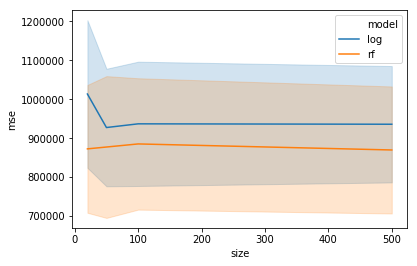

In [180]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(bootstrap)
import seaborn as sns
ax = sns.lineplot(x="size", y="mse",
             hue="model",ci='sd', 
             data=err)
# ax.fill_between(bootstrap.size, bootstrap.LB, bootstrap.UB, color='#888888', alpha=0.2)

plt.show()

1. Remove all unnecessary features and save df
2. Transform emoji to be processable
3. Remove NaN values